In [22]:
import mysql.connector
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import rc
%matplotlib inline
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15) 

In [23]:
dotenv_path = "../.env"
load_dotenv(dotenv_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

conn = mysql.connector.connect(
    host = db_host,
    port = db_port,
    database = db_name,
    user = db_user,
    password = db_password
)

mycursor = conn.cursor()

def show_sql_result(sql):
       mycursor.execute(sql)
       rows = mycursor.fetchall()
       columns = [column[0] for column in mycursor.description]
       table_data = pd.DataFrame(rows, columns=columns)
       return table_data

## 최초구매일에 따른 cohort

In [116]:
sql = '''
SELECT
    CustomerID,
    TransactionID,
    TransactionDate, 
    MIN(TransactionDate) OVER (PARTITION BY CustomerID) AS 최초구매일,
    Quantity * AverageAmount AS 거래매출액
FROM
    sales
;
'''
first_buy = show_sql_result(sql)
first_buy

,CustomerID,TransactionID,TransactionDate,최초구매일,거래매출액
0,USER_0000,Transaction_16900,2019-09-15,2019-09-15,11.00
1,USER_0000,Transaction_16900,2019-09-15,2019-09-15,19.99
2,USER_0001,Transaction_20187,2019-11-02,2019-03-24,18.75
3,USER_0001,Transaction_20182,2019-11-02,2019-03-24,149.00
4,USER_0001,Transaction_20181,2019-11-02,2019-03-24,149.00
...,...,...,...,...,...
52919,USER_1467,Transaction_13435,2019-07-29,2019-07-29,238.00
52920,USER_1467,Transaction_13434,2019-07-29,2019-07-29,119.00
52921,USER_1467,Transaction_13433,2019-07-29,2019-07-29,4.56
52922,USER_1467,Transaction_13433,2019-07-29,2019-07-29,16.79


In [117]:
first_buy['TransactionDate'] = pd.to_datetime(first_buy['TransactionDate'])
first_buy['최초구매일'] = pd.to_datetime(first_buy['최초구매일'])
first_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       52924 non-null  object        
 1   TransactionID    52924 non-null  object        
 2   TransactionDate  52924 non-null  datetime64[ns]
 3   최초구매일            52924 non-null  datetime64[ns]
 4   거래매출액            52924 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 2.0+ MB


In [118]:
month_diff = first_buy['TransactionDate'].dt.month - first_buy['최초구매일'].dt.month
month_diff.value_counts()

0     32033
5      3538
3      2782
6      2520
4      2251
2      2175
7      2097
1      1941
8      1107
9      1021
11      749
10      710
Name: count, dtype: int64

In [119]:
# 최소값을 1로 설정
first_buy['cohort_index'] = month_diff + 1
first_buy['cohort_index'].value_counts()

cohort_index
1     32033
6      3538
4      2782
7      2520
5      2251
3      2175
8      2097
2      1941
9      1107
10     1021
12      749
11      710
Name: count, dtype: int64

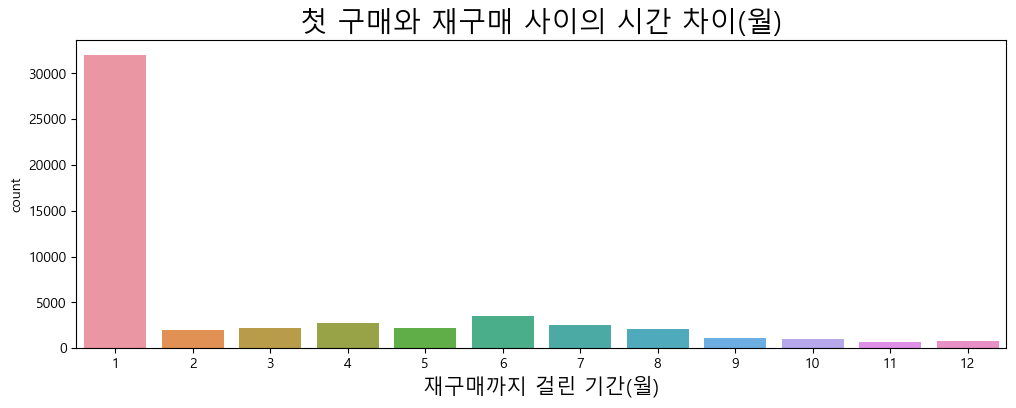

In [120]:
plt.figure(figsize=(12, 4))
sns.countplot(data=first_buy, x='cohort_index')
plt.title('첫 구매와 재구매 사이의 시간 차이(월)', fontsize=20)
plt.xlabel('재구매까지 걸린 기간(월)', fontsize=15)
plt.show()

In [121]:
first_buy['최초구매월'] = first_buy['최초구매일'].astype(str).str[:7]
cohort_count = first_buy.groupby(['최초구매월', 'cohort_index'])['CustomerID'].nunique().unstack()
cohort_count

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
최초구매월,,,,,,,,,,,,
2019-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN
2019-06,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2019-07,94.0,13.0,4.0,6.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,135.0,14.0,15.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


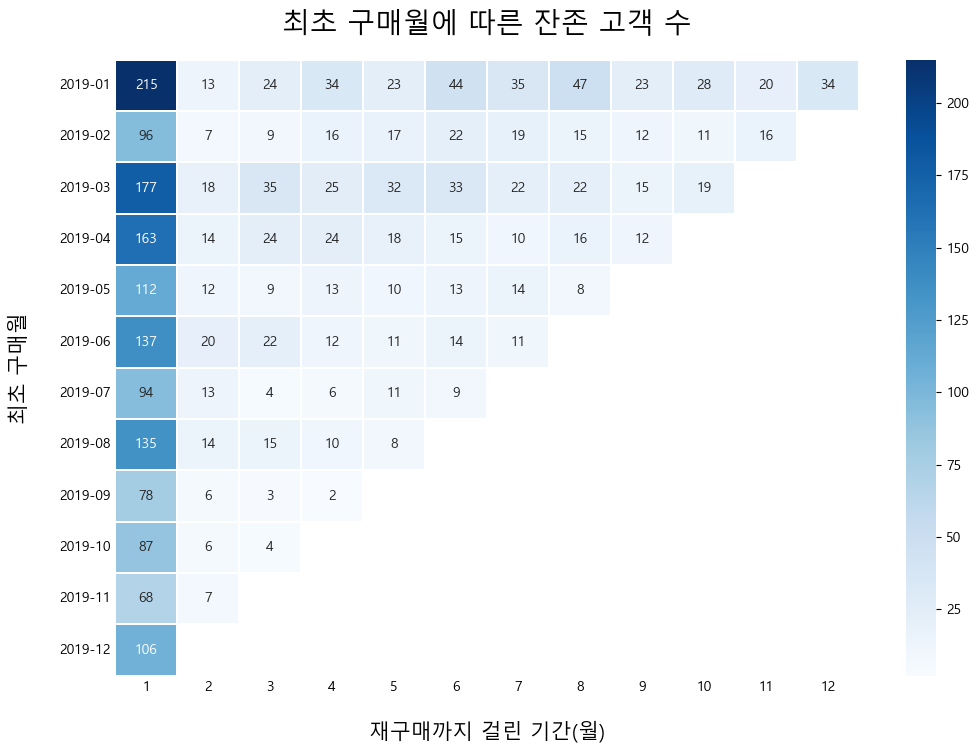

In [122]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_count, cmap='Blues', annot=True, fmt='.0f', linewidths=0.1, linecolor='w')
plt.title('최초 구매월에 따른 잔존 고객 수', fontsize=20, pad=20)
plt.xlabel('재구매까지 걸린 기간(월)', fontsize=15, labelpad=20)
plt.ylabel('최초 구매월', fontsize=15, labelpad=20)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, length=0)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, length=0)

plt.show()

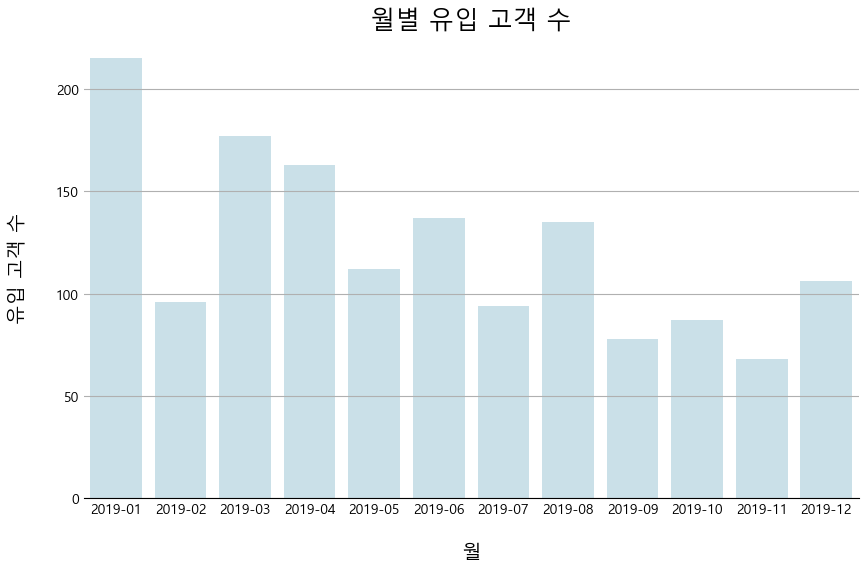

In [123]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=cohort_count.index, y=cohort_count[1], color='lightblue', alpha=0.7, label='유입 고객 수')
ax.set_ylabel('유입 고객 수', fontsize=14, labelpad=20)
ax.set_xlabel('월', fontsize=14, labelpad=20)

ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis="y", which="major")

plt.title('월별 유입 고객 수', fontsize=18)
plt.show()


- 가입기간이 별도로 있기 때문에 '유입 고객'이 '신규 고객'을 의미한다고 볼 수 없음

In [124]:
cohort_norm = cohort_count.div(cohort_count[1], axis=0)
cohort_norm

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
최초구매월,,,,,,,,,,,,
2019-01,1.0,0.060465,0.111628,0.158140,0.106977,0.204651,0.162791,0.218605,0.106977,0.130233,0.093023,0.15814
2019-02,1.0,0.072917,0.093750,0.166667,0.177083,0.229167,0.197917,0.156250,0.125000,0.114583,0.166667,NaN
2019-03,1.0,0.101695,0.197740,0.141243,0.180791,0.186441,0.124294,0.124294,0.084746,0.107345,NaN,NaN
2019-04,1.0,0.085890,0.147239,0.147239,0.110429,0.092025,0.061350,0.098160,0.073620,NaN,NaN,NaN
2019-05,1.0,0.107143,0.080357,0.116071,0.089286,0.116071,0.125000,0.071429,NaN,NaN,NaN,NaN
2019-06,1.0,0.145985,0.160584,0.087591,0.080292,0.102190,0.080292,NaN,NaN,NaN,NaN,NaN
2019-07,1.0,0.138298,0.042553,0.063830,0.117021,0.095745,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,1.0,0.103704,0.111111,0.074074,0.059259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,1.0,0.076923,0.038462,0.025641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


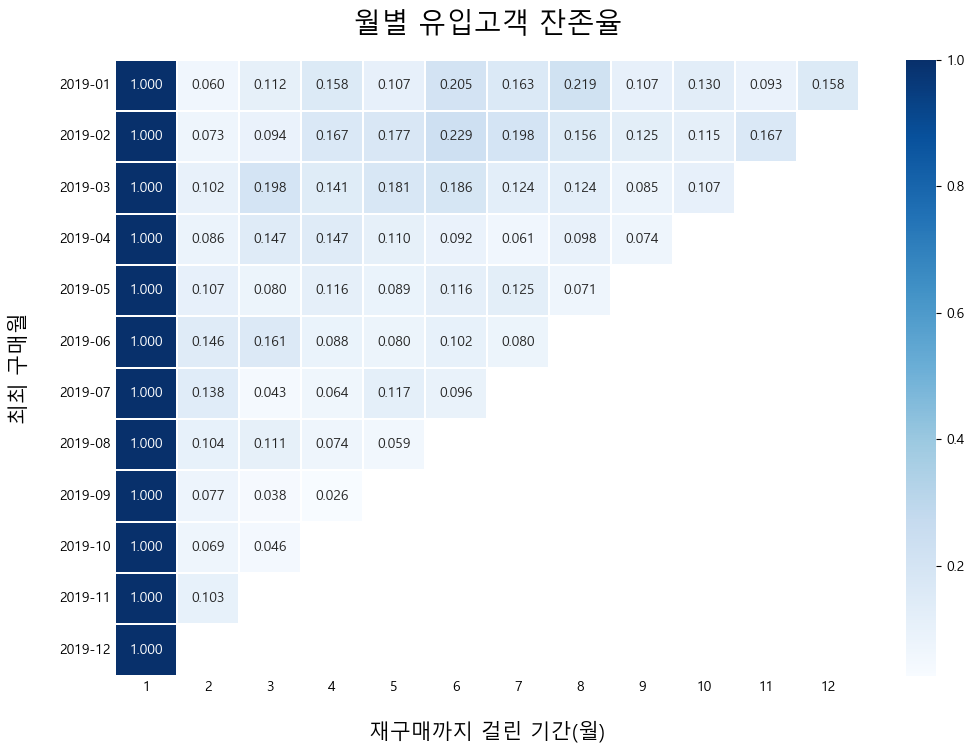

In [125]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_norm, cmap='Blues', annot=True, fmt='.3f', linewidths=0.1, linecolor='w')
plt.title('월별 유입고객 잔존율', fontsize=20, pad=20)
plt.xlabel('재구매까지 걸린 기간(월)', fontsize=15, labelpad=20)
plt.ylabel('최최 구매월', fontsize=15, labelpad=20)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, length=0)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, length=0)

plt.show()

- 1분기 유입 고객의 잔존율이 비교적 높음

In [126]:
first_buy

,CustomerID,TransactionID,TransactionDate,최초구매일,거래매출액,cohort_index,최초구매월
0,USER_0000,Transaction_16900,2019-09-15,2019-09-15,11.00,1,2019-09
1,USER_0000,Transaction_16900,2019-09-15,2019-09-15,19.99,1,2019-09
2,USER_0001,Transaction_20187,2019-11-02,2019-03-24,18.75,9,2019-03
3,USER_0001,Transaction_20182,2019-11-02,2019-03-24,149.00,9,2019-03
4,USER_0001,Transaction_20181,2019-11-02,2019-03-24,149.00,9,2019-03
...,...,...,...,...,...,...,...
52919,USER_1467,Transaction_13435,2019-07-29,2019-07-29,238.00,1,2019-07
52920,USER_1467,Transaction_13434,2019-07-29,2019-07-29,119.00,1,2019-07
52921,USER_1467,Transaction_13433,2019-07-29,2019-07-29,4.56,1,2019-07
52922,USER_1467,Transaction_13433,2019-07-29,2019-07-29,16.79,1,2019-07


In [131]:
cohort_total = first_buy.groupby(['최초구매월', 'cohort_index'])['거래매출액'].sum().unstack()
cohort_total

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
최초구매월,,,,,,,,,,,,
2019-01,403624.58,39230.64,46645.94,114342.41,29081.40,51392.43,83164.89,49687.83,40313.12,45824.79,40757.46,93254.57
2019-02,271589.16,8095.60,12709.89,21995.59,23458.86,41188.56,22313.65,44942.13,17146.07,28988.81,47910.20,NaN
2019-03,294866.55,41053.03,36365.25,30603.93,46287.73,70783.91,47920.00,39753.48,24759.69,36501.82,NaN,NaN
2019-04,233513.09,23132.37,16597.02,29717.78,25249.90,30148.90,15698.45,57088.59,18185.16,NaN,NaN,NaN
2019-05,197188.81,6872.73,11887.83,14110.62,17265.29,36035.79,37881.79,11455.74,NaN,NaN,NaN,NaN
2019-06,192156.41,10454.74,12707.64,15341.33,9955.26,36710.35,15475.08,NaN,NaN,NaN,NaN,NaN
2019-07,149936.54,14812.07,7331.90,14796.05,24362.10,29016.88,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,191544.75,10715.23,11079.85,28956.08,16715.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,146570.50,1875.06,2556.36,662.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
cohort_total = cohort_total.astype(float)

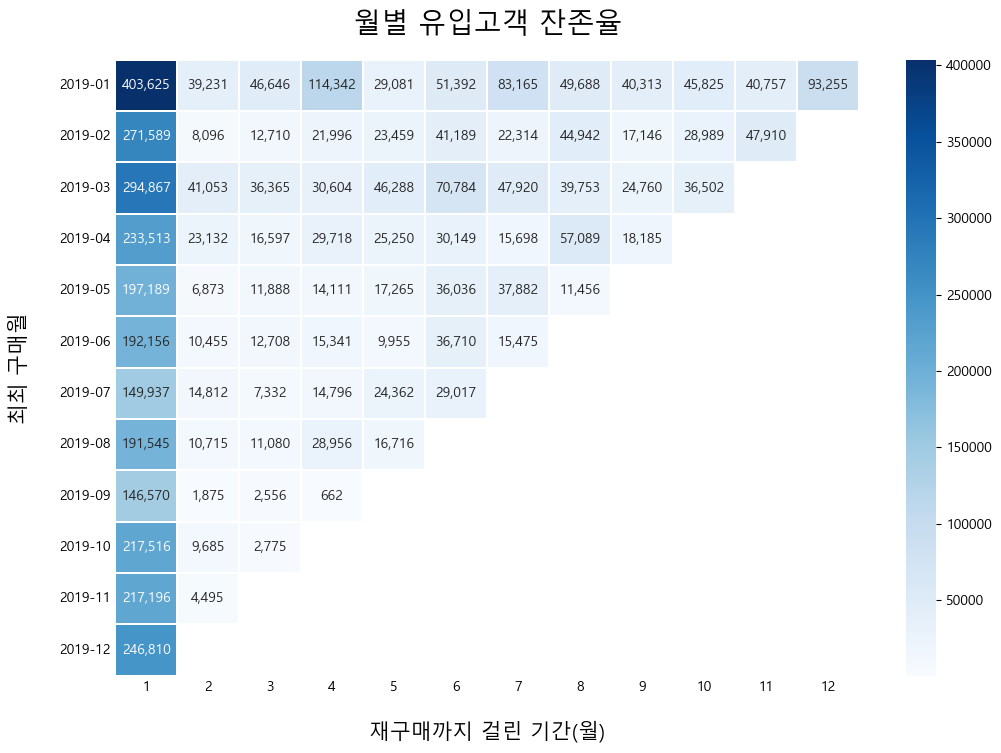

In [139]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_total, cmap='Blues', annot=True, fmt=',.0f', linewidths=0.1, linecolor='w')
plt.title('월별 유입고객 잔존율', fontsize=20, pad=20)
plt.xlabel('재구매까지 걸린 기간(월)', fontsize=15, labelpad=20)
plt.ylabel('최최 구매월', fontsize=15, labelpad=20)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, length=0)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, length=0)

plt.show()

- 19년 1월 유입 고객들이 꾸준히 매출을 기록
- 1분기(1월~3월) 유입고객은 3만불 이상의 비교적 높은 매출을 유지
- 19년도에 일시적인 현상인지, 꾸준한 패턴인지 확인
    - 매년 발생하는 현상이라면, 연초 구매를 하는 고객의 특성을 분석해 마케팅에 활용할 수 있음

## 가입기간에 따른 cohort

In [141]:
sql = '''
SELECT
    s.CustomerID,
    c.SubscriptionPeriod AS 가입기간,
    COUNT(DISTINCT s.TransactionID) AS 구매건수,
    COUNT(DISTINCT s.TransactionDate) AS 구매일수,
    MIN(s.TransactionDate) AS 최초구매일,
    MAX(s.TransactionDate) AS 최근구매일,
    SUM(s.Quantity * s.AverageAmount) AS 총지출액,
    SUM(CASE WHEN s.CouponStatus='Used' THEN 1 ELSE 0 END) AS 사용쿠폰수,
    COUNT(DISTINCT ProductID) AS 구매제품종류
FROM
    sales s
JOIN
    customer c
ON
    s.CustomerID = c.CustomerID
GROUP BY
    s.CustomerID
;
'''
data = show_sql_result(sql)
data

,CustomerID,가입기간,구매건수,구매일수,최초구매일,최근구매일,총지출액,사용쿠폰수,구매제품종류
0,USER_0000,31,1,1,2019-09-15,2019-09-15,30.99,2,2
1,USER_0001,20,31,3,2019-03-24,2019-11-02,13834.90,20,42
2,USER_0002,39,8,2,2019-06-22,2019-10-19,1442.12,11,21
3,USER_0003,25,11,1,2019-12-14,2019-12-14,1360.07,6,11
4,USER_0004,31,13,1,2019-09-15,2019-09-15,1442.47,11,33
...,...,...,...,...,...,...,...,...,...
1463,USER_1463,5,3,1,2019-04-05,2019-04-05,544.34,3,7
1464,USER_1464,43,19,3,2019-06-22,2019-10-05,2363.05,16,35
1465,USER_1465,25,2,2,2019-04-05,2019-06-20,101.56,3,8
1466,USER_1466,47,1,1,2019-10-23,2019-10-23,298.00,0,1


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  1468 non-null   object
 1   가입기간        1468 non-null   int64 
 2   구매건수        1468 non-null   int64 
 3   구매일수        1468 non-null   int64 
 4   최초구매일       1468 non-null   object
 5   최근구매일       1468 non-null   object
 6   총지출액        1468 non-null   object
 7   사용쿠폰수       1468 non-null   object
 8   구매제품종류      1468 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 103.3+ KB


In [143]:
data['최초구매일'] = pd.to_datetime(data['최초구매일'])
data['최근구매일'] = pd.to_datetime(data['최근구매일'])
data['총지출액'] = data['총지출액'].astype(float)
data['사용쿠폰수'] = data['사용쿠폰수'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CustomerID  1468 non-null   object        
 1   가입기간        1468 non-null   int64         
 2   구매건수        1468 non-null   int64         
 3   구매일수        1468 non-null   int64         
 4   최초구매일       1468 non-null   datetime64[ns]
 5   최근구매일       1468 non-null   datetime64[ns]
 6   총지출액        1468 non-null   float64       
 7   사용쿠폰수       1468 non-null   int32         
 8   구매제품종류      1468 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(4), object(1)
memory usage: 97.6+ KB


In [145]:
cohort_analysis = data.groupby('가입기간').agg({
    '구매건수': 'mean',
    '구매일수': 'mean',
    '총지출액': 'mean',
    '사용쿠폰수': 'mean',
    '구매제품종류': 'mean'
}).reset_index()

In [146]:
cohort_analysis.head()

,가입기간,구매건수,구매일수,총지출액,사용쿠폰수,구매제품종류
0,2,12.846154,1.846154,1992.125769,9.346154,19.500000
1,3,14.086957,2.043478,2318.196957,9.608696,20.434783
2,4,13.842105,1.631579,2281.823158,8.947368,22.157895
3,5,25.200000,2.533333,4809.083333,17.833333,34.600000
4,6,18.944444,2.166667,3277.142500,12.611111,25.305556
5,7,15.548387,2.322581,2606.755806,9.774194,23.806452
6,8,22.071429,1.964286,3382.359286,13.571429,29.785714
7,9,10.857143,1.857143,1854.984643,7.035714,19.214286
8,10,21.294118,3.117647,3854.256176,14.617647,31.500000
9,11,18.920000,2.920000,3792.529600,12.040000,26.000000


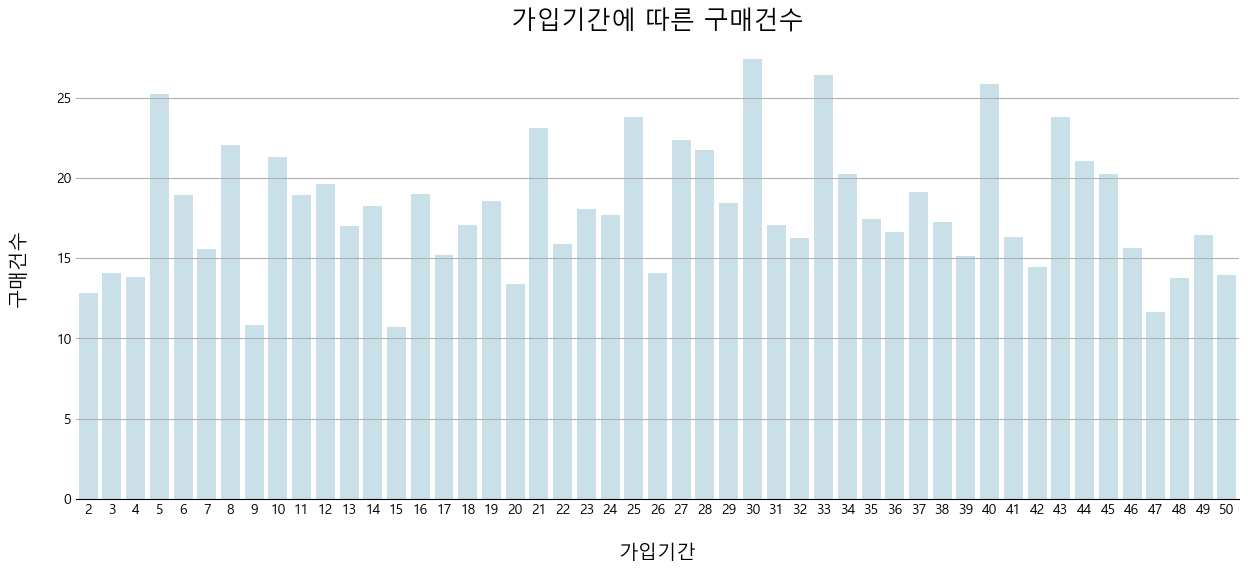

In [150]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(x=cohort_analysis.가입기간, y=cohort_analysis.구매건수, color='lightblue', alpha=0.7, label='유입 고객 수')
ax.set_ylabel('구매건수', fontsize=14, labelpad=20)
ax.set_xlabel('가입기간', fontsize=14, labelpad=20)

ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis="y", which="major")

plt.title('가입기간에 따른 구매건수', fontsize=18)
plt.show()

In [151]:
from datetime import datetime

base_date = datetime(2019, 12, 31)

data['가입년월'] = data.apply(lambda row: (base_date - pd.DateOffset(months=row['가입기간'])).strftime('%Y-%m'), axis=1)
data

,CustomerID,가입기간,구매건수,구매일수,최초구매일,최근구매일,총지출액,사용쿠폰수,구매제품종류,가입년월
0,USER_0000,31,1,1,2019-09-15,2019-09-15,30.99,2,2,2017-05
1,USER_0001,20,31,3,2019-03-24,2019-11-02,13834.90,20,42,2018-04
2,USER_0002,39,8,2,2019-06-22,2019-10-19,1442.12,11,21,2016-09
3,USER_0003,25,11,1,2019-12-14,2019-12-14,1360.07,6,11,2017-11
4,USER_0004,31,13,1,2019-09-15,2019-09-15,1442.47,11,33,2017-05
...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,5,3,1,2019-04-05,2019-04-05,544.34,3,7,2019-07
1464,USER_1464,43,19,3,2019-06-22,2019-10-05,2363.05,16,35,2016-05
1465,USER_1465,25,2,2,2019-04-05,2019-06-20,101.56,3,8,2017-11
1466,USER_1466,47,1,1,2019-10-23,2019-10-23,298.00,0,1,2016-01


In [159]:
anomaly_data = data[data['최초구매일'] < pd.to_datetime(data['가입년월'])]
anomaly_data['가입년월'].value_counts()

가입년월
2019-08    24
2019-07    22
2019-10    20
2019-09    15
2019-05    15
2019-06    14
2019-04     8
2019-03     7
2019-02     6
Name: count, dtype: int64

- 전체 1468명 중 131명의 고객이 기준일 19.12.31로 가입년월을 계산시 최초구매일이 가입년월이 더 빠름

In [157]:
data.loc[(data['최초구매일'] >= pd.to_datetime(data['가입년월']))&(pd.to_datetime(data['가입년월']).dt.year==2019)]

,CustomerID,가입기간,구매건수,구매일수,최초구매일,최근구매일,총지출액,사용쿠폰수,구매제품종류,가입년월
13,USER_0013,10,14,3,2019-02-09,2019-07-20,1383.64,9,30,2019-02
15,USER_0015,8,14,1,2019-12-21,2019-12-21,2297.30,4,23,2019-04
22,USER_0022,9,8,1,2019-07-12,2019-07-12,725.93,7,15,2019-03
32,USER_0032,9,7,1,2019-11-10,2019-11-10,1379.78,3,10,2019-03
33,USER_0033,11,70,11,2019-01-18,2019-12-16,13907.84,40,73,2019-01
...,...,...,...,...,...,...,...,...,...,...
1427,USER_1427,6,11,2,2019-07-10,2019-07-16,1426.12,5,14,2019-06
1435,USER_1435,3,45,2,2019-11-12,2019-11-13,10860.11,29,45,2019-09
1446,USER_1446,6,13,2,2019-08-04,2019-09-12,1817.14,17,25,2019-06
1447,USER_1447,8,6,2,2019-08-26,2019-09-18,413.74,3,10,2019-04


- 2019년 가입자 299명 중 131명은 최초 구매일이 가입년월보다 빠른 이상데이터

In [161]:
normal_data = data.loc[(data['최초구매일'] >= pd.to_datetime(data['가입년월']))]
normal_data

,CustomerID,가입기간,구매건수,구매일수,최초구매일,최근구매일,총지출액,사용쿠폰수,구매제품종류,가입년월
0,USER_0000,31,1,1,2019-09-15,2019-09-15,30.99,2,2,2017-05
1,USER_0001,20,31,3,2019-03-24,2019-11-02,13834.90,20,42,2018-04
2,USER_0002,39,8,2,2019-06-22,2019-10-19,1442.12,11,21,2016-09
3,USER_0003,25,11,1,2019-12-14,2019-12-14,1360.07,6,11,2017-11
4,USER_0004,31,13,1,2019-09-15,2019-09-15,1442.47,11,33,2017-05
...,...,...,...,...,...,...,...,...,...,...
1462,USER_1462,45,2,1,2019-07-05,2019-07-05,49.56,0,4,2016-03
1464,USER_1464,43,19,3,2019-06-22,2019-10-05,2363.05,16,35,2016-05
1465,USER_1465,25,2,2,2019-04-05,2019-06-20,101.56,3,8,2017-11
1466,USER_1466,47,1,1,2019-10-23,2019-10-23,298.00,0,1,2016-01


In [181]:
temp1 = normal_data.groupby(pd.to_datetime(normal_data['가입년월']).dt.year, as_index=False)['CustomerID'].size()
temp1

,가입년월,size
0,2015,88
1,2016,347
2,2017,381
3,2018,353
4,2019,168


In [182]:
temp2 = normal_data.groupby(pd.to_datetime(normal_data['가입년월']).dt.year)[['총지출액']].sum().reset_index()
temp2

,가입년월,총지출액
0,2015,230647.61
1,2016,1119871.39
2,2017,1383080.75
3,2018,1029809.15
4,2019,458765.44


In [185]:
cohort_join = pd.merge(left=temp1, right=temp2, on='가입년월').rename(columns={'size':'고객수', '총지출액':'지출액_합계'})
cohort_join

,가입년월,고객수,지출액_합계
0,2015,88,230647.61
1,2016,347,1119871.39
2,2017,381,1383080.75
3,2018,353,1029809.15
4,2019,168,458765.44


In [187]:
cohort_join['지출액_평균'] = round(cohort_join['지출액_합계'] / cohort_join['고객수'], 2)
cohort_join

,가입년월,고객수,지출액_합계,지출액_평균
0,2015,88,230647.61,2621.00
1,2016,347,1119871.39,3227.30
2,2017,381,1383080.75,3630.13
3,2018,353,1029809.15,2917.31
4,2019,168,458765.44,2730.75


In [188]:
min(pd.to_datetime(normal_data['가입년월']))

Timestamp('2015-10-01 00:00:00')

- 19년은 이상데이터 131명을 포함해도 지난 3년간에 비해 가입 고객이 적었음
- 가장 빠른 가입 고객은 15년 10월 가입. 이전 데이터는 확인되지 않음

> 인사이트
- 2015년부터 2017년까지 고객수가 지소적으로 증가했으며, 2017년 이후 고객 감소 추세
- 고객별 지출액 평균도 17년도 가입 고객들의 매출이 가장 높게 나타남
- 2019년 8월, Nest 카테코리 출시로 매출 증가가 기대되는 상황에서, 신규 고객을 유치하고 기존 고객을 유지하기 위한 마케팅이 중요

In [202]:
df_month = normal_data.groupby('가입년월', as_index=False)['CustomerID'].size()
df_month['연도'] = df_month['가입년월'].str[:4].astype(int)
df_month['월'] = df_month['가입년월'].str[-2:].astype(int)
df_month = df_month.rename(columns={'size':'고객수'}).copy()
df_month.head()

,가입년월,고객수,연도,월
0,2015-10,28,2015,10
1,2015-11,26,2015,11
2,2015-12,34,2015,12
3,2016-01,23,2016,1
4,2016-02,26,2016,2


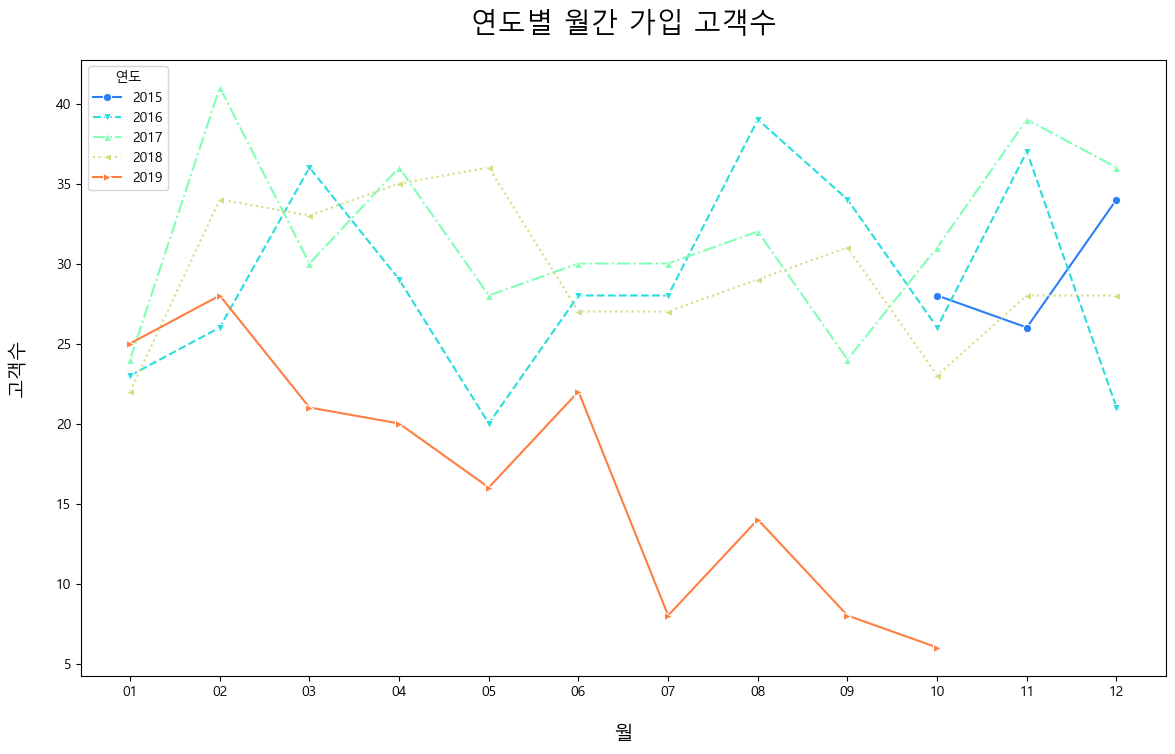

In [215]:
plt.figure(figsize=(14, 8))
styles = ['-', '--', '-.', ':']
markers = ['o', 'v', '^', '<', '>']
palette = sns.color_palette("rainbow", n_colors=df_month['연도'].nunique())

for i, (year, group_data) in enumerate(df_month.groupby('연도')):
    sns.lineplot(data=group_data, x='월', y='고객수', 
                 color=palette[i], linestyle=styles[i % len(styles)], 
                 marker=markers[i % len(markers)], label=year)
    
plt.title('연도별 월간 가입 고객수', fontsize=20, pad=20)
plt.xlabel('월', fontsize=14, labelpad=20)
plt.ylabel('고객수', fontsize=14, labelpad=20)
plt.legend(title='연도')
plt.xticks(range(1, 13), labels=[str(i).zfill(2) for i in range(1, 13)])
plt.show()

- 2019년은 다른 해와 다른 양상을 보임 -> 이상데이터 제외로 인한 영향일 수 있음
- 연도별로 차이는 있지만, 대체로 2월과 8월에 가입 고객수가 피크. 이후 연말에 다시 증가. 계절성이 나타남.
    - 특정 시즌에 마케팅 캠페인이 있었을 것으로 추정

In [221]:
normal_data = normal_data.copy()
normal_data.loc[:, '가입월'] = normal_data['가입년월'].str[-2:]
normal_data.groupby('가입월')['총지출액'].mean()

가입월
01    3024.712660
02    3302.729457
03    3816.631583
04    3100.805083
05    2868.140100
06    3332.399626
07    2964.702796
08    4010.795000
09    2709.157113
10    2492.380965
11    3254.417154
12    2818.354538
Name: 총지출액, dtype: float64

- 3월, 8월 가입고객들의 지출액 평균이 높음. 2월, 8월에 가입 고객수가 피크를 찍었던 것과 연결하면 계절에 따른 프로모션의 영향이었을 것
- 10월 가입 고객들의 지출액이 낮은 것은 연말 쇼핑을 대비해 지출을 미루고 있음을 시사할 수 있음
- 12월은 연말, 크리스마스 시즌으로 일반적으로 소비가 증가할 것으로 기대하지만, 12월 가입 고객들의 지출액은 생각보다 크지 않음

## 주말/주중 cohort

## 주차별 cohort

## 관심사(최다지출 카테고리, 최다구매 카테고리) cohort

In [222]:
mycursor.close()
conn.close()